In [115]:
using AgentBasedModels
abm = AgentBasedModels

using Random
using Distributions
using CUDA

using GLMakie

# Define the agent

In [125]:
m = @agent(saiz,
    
    #Mechanics
    
    [x,y,z,vx,vy,vz]::Local, #Variables
    [Fix,Fiy,Fiz]::Local,    #Interaction forces
    id::Identity,            #Identity
    [m,r]::Local,            #Mass and radius of the model
    [μ,b]::Global,           #Global parameters of the model
    F₀::Global,         #Matrix of interaction forces
    
    Equation = begin
        d_vx = (-b*vx/m+Fix/m)*dt
        d_vy = (-b*vy/m+Fiy/m)*dt
        d_vz = (-b*vz/m+Fiz/m)*dt
        d_x = vx*dt
        d_y = vy*dt
        d_z = vz*dt
    end,
    
    UpdateInteraction = begin
        dij = sqrt((x_i-x_j)^2+(y_i-y_j)^2+(z_i-z_j)^2)
        rij = r_i+r_j
        if dij < μ*rij && dij > 0
            Fix += F₀*(rij/dij-1)*(μ*rij/dij-1)*(x_i-x_j)/dij
            Fiy += F₀*(rij/dij-1)*(μ*rij/dij-1)*(y_i-y_j)/dij
            Fiz += F₀*(rij/dij-1)*(μ*rij/dij-1)*(z_i-z_j)/dij   
        end
    end,
    
    #Biochemistry
    
    c::Local,             #Biochemical component
    [ci,ni]::Local,       #Interaction parameters for the mean
    toff::Local,
    [α,n,mm,K]::Global,
    [frange,fmin,fmax]::Global,       #Distance of communication
    Non::Global,
    
    Equation = begin
        if t < toff && N > Non
            d_c = (α*(1+c^n)^mm/((1+c^n)^mm+(1+(ci/ni)/K)^(2*mm))-c)*dt
        else
            d_c = 0*dt
        end
    end,
        
    UpdateInteraction= begin
        if dij < frange*rij #Unnecessary to compute dij and rij again, previously computed in UpdateInteraction
            ni += 1
            ci += c_j
        end 
    end,
    
    #Growth
    
    tu::Local,
    [τdiv,σdiv,σc]::Global,

    EventDivision = begin
        if t > tu
            #Choose random direction in unit sphere
            xₐ = Normal(0,1); yₐ = Normal(0,1); zₐ = Normal(0,1)
            Tₐ = sqrt(xₐ^2+yₐ^2+zₐ^2)
            xₐ /= Tₐ;yₐ /= Tₐ;zₐ /= Tₐ    

            #Chose a random distribution
            dist = Uniform(1-σc,1+σc)

            #Update things of first cell
            x_1 = x+r*xₐ/2; y_1 = y+r*yₐ/2; z_1 = z+r*zₐ/2
            vx_1 = 0.; vy_1 = 0.; vz_1 = 0.
            r_1 = r/2. ^(1. /3)
            m_1 = m/2
            tu_1 = t + Uniform(τdiv-σdiv,τdiv+σdiv)
            c_1 = c*dist

            #Update things of second cell
            x_2 = x-r*xₐ/2; y_2 = y-r*yₐ/2; z_2 = z-r*zₐ/2
            vx_2 = 0.; vy_2 = 0.; vz_2 = 0.
            r_2 = r/2. ^(1. /3)
            m_2 = m/2
            tu_2 = t + Uniform(τdiv-σdiv,τdiv+σdiv)
            c_2 = c*(2-dist)
        end
    end,
)

PARAMETERS
Identity
	 agentId, id,
Global
	 μ, b, F₀, α, n, mm, K, frange, fmin, fmax, Non, τdiv, σdiv, σc,
Local
	 x, y, z, vx, vy, vz, Fix, Fiy, Fiz, m, r, c, ci, ni, toff, tu,


UPDATE RULES
Equation
 begin
    d_vx = ((-b * vx) / m + Fix / m) * dt
    d_vy = ((-b * vy) / m + Fiy / m) * dt
    d_vz = ((-b * vz) / m + Fiz / m) * dt
    d_x = vx * dt
    d_y = vy * dt
    d_z = vz * dt
    if t < toff && N > Non
        d_c = ((α * (1 + c ^ n) ^ mm) / ((1 + c ^ n) ^ mm + (1 + (ci / ni) / K) ^ (2mm)) - c) * dt
    else
        d_c = 0dt
    end
end

EventDivision
 begin
    if t > tu
        xₐ = Normal(0, 1)
        yₐ = Normal(0, 1)
        zₐ = Normal(0, 1)
        Tₐ = sqrt(xₐ ^ 2 + yₐ ^ 2 + zₐ ^ 2)
        xₐ /= Tₐ
        yₐ /= Tₐ
        zₐ /= Tₐ
        dist = Uniform(1 - σc, 1 + σc)
        x_1 = x + (r * xₐ) / 2
        y_1 = y + (r * yₐ) / 2
        z_1 = z + (r * zₐ) / 2
        vx_1 = 0.0
        vy_1 = 0.0
        vz_1 = 0.0
        r_1 = r / 2.0 ^ (1.0 / 3)
        m_1 =

# Compile the model

In [126]:
mCompiled = compile(m,platform="cpu",save="RAM",integrator="Heun",debug=false);

# Initialise the Community

In [147]:
com = Community(mCompiled,N=1)

##########Mechanics##############################
#Initialise global
com.b = 10^-6
com.F₀ = 10^-4 #.*zeros(2,2)
com.μ = 2

#########Division#################################
#Initialise global
com.τdiv = 10
com.σdiv = 0.5
com.σc = 0.01

#########Chemical#################################
#Initialise Global
com.Non = 3 #Start deactivated
com.fmin = 0.05
com.fmax = 0.95
com.α = 10
com.n = 2
com.mm = 2
com.K = 0.9
com.frange = 1.2

#########Local parameters and variables###########
#Initialise locals
mᵢ = 10^-6
rᵢ = 5
com.m .= mᵢ
com.r .= rᵢ
com.id .= 1 #Start neutral fate
com.toff .= 10 #Start activated
#Initialise variables
com.x .= 0. #They are only separed in this axis
com.y .= 0.
com.z .= 0.
com.vx .= 0.
com.vy .= 0.
com.vz .= 0.

c₀=3.
com.c .= c₀
com.tu .= 10.

1-element view(::Matrix{Float64}, :, 16) with eltype Float64:
 10.0

In [148]:
c = mCompiled.evolve(com,dt=0.001,tMax=60,nMax=1000);

In [215]:
c[end].N

54

## Visualization

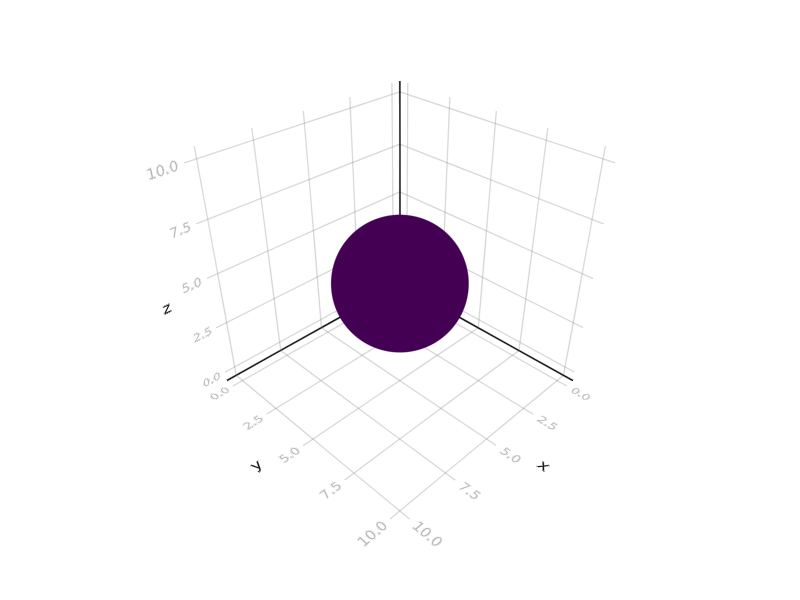

In [251]:
i = 1000
x = c[i].x
y = c[i].y
z = c[i].z
r = c[i].r;
col = c[i].c;
    
fig = scatter([0,10,0,0],[0,0,10,0],[0,0,0,10],markersize=0.00001)
scatter!(fig.axis,x,y,z,markersize=1000*r,color=col)
fig

In [248]:
for i in 1:2000:60000

    #i = 1000
    x = c[i].x
    y = c[i].y
    z = c[i].z
    r = c[i].r;
    col = c[i].c;
    
    fig = scatter([0,10,0,0],[0,0,10,0],[0,0,0,10],markersize=0.00001)
    scatter!(fig.axis,x,y,z,markersize=1000*r,color=col)

    save(string("it",i,".png"),fig)
    
end